In [30]:
#This code contains visualizations for ML clustering and regression

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

random_state = 42

%matplotlib inline

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
df = pd.read_csv('/content/drive/MyDrive/user_behavior_dataset.csv')

Using Clustering Algorithms


In [34]:
feature_cols = ["App Usage Time (min/day)", "Screen On Time (hours/day)", "Battery Drain (mAh/day)", "Number of Apps Installed", "Data Usage (MB/day)"]

X = df[feature_cols] #X is used for convention and here we are taking these columns as features to categorize how heavy/light a user is.

# Keep copy of original dataset to add clustering output (y values) and then visualize the clustering based on the cluster it falls into
df_clust = df.loc[X.index].copy()


In [35]:
#Performing scaling (standard scaler does x - u / sigma where u is mean and sigma is standard deviation). Good practice to avoid outlies
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

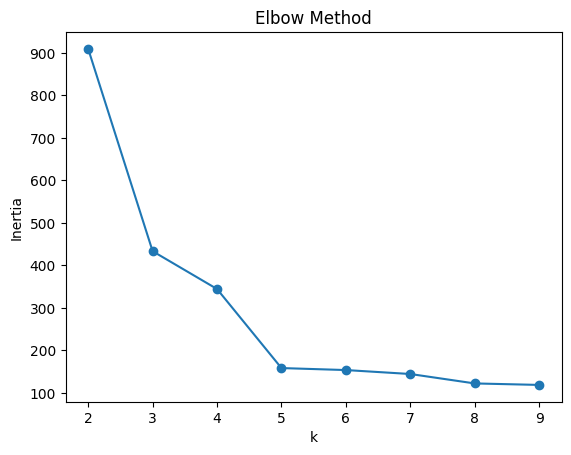

In [36]:
#Using elbow method to get the best k value for our task by training on the training data
inertias = [] #Within-Cluster Sum of Squares is also called as inertia
k_values = range(2, 10)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [37]:
best_k = 5 #From above plot

km = KMeans(n_clusters=best_k, random_state=random_state) #Training it with the best k value
y = km.fit_predict(X_scaled) #This is used to get category output values (i.e. y in supervised learning)

df_clust["category"] = y #Assigning which user falls into which category or cluster
print(df_clust)

     User ID        Device Model Operating System  App Usage Time (min/day)  \
0          1      Google Pixel 5          Android                       393   
1          2           OnePlus 9          Android                       268   
2          3        Xiaomi Mi 11          Android                       154   
3          4      Google Pixel 5          Android                       239   
4          5           iPhone 12              iOS                       187   
..       ...                 ...              ...                       ...   
695      696           iPhone 12              iOS                        92   
696      697        Xiaomi Mi 11          Android                       316   
697      698      Google Pixel 5          Android                        99   
698      699  Samsung Galaxy S21          Android                        62   
699      700           OnePlus 9          Android                       212   

     Screen On Time (hours/day)  Battery Drain (mAh

In [38]:
category_details = df_clust.groupby("category")[feature_cols].mean()
category_details
#This table gives a clear insight of the cluster/category and how it is able to differentate people (mean is the statistic used here)
#3 light user, 1 moderate user, 2 heavy user, 4 very heavy user, 0 extreme user (based on all features, it is evident)

,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day)
category,,,,,
0,541.419118,10.114706,2701.014706,89.250000,1974.772059
1,131.972603,3.037671,883.808219,30.753425,451.417808
2,235.398601,4.955944,1515.055944,50.000000,822.013986
3,60.426471,1.490441,454.977941,14.558824,202.323529
4,395.748201,6.909353,2105.805755,69.920863,1232.230216


In [39]:
#Lets grab the clusters and now try to get the categories as mentioned above so that we can read the plot!
sorted_categories = category_details["Screen On Time (hours/day)"].sort_values().index.tolist()

type_of_user = ["Light User", "Moderate User", "Heavy User", "Very Heavy User", "Extreme User"] #creating a list of names to zip it with category

category_to_label = {}  # Create empty dictionary to map category to the label

for category_id, label in zip(sorted_categories, type_of_user):
    category_to_label[category_id] = label

df_clust["Type of User"] = df_clust["category"].map(category_to_label)


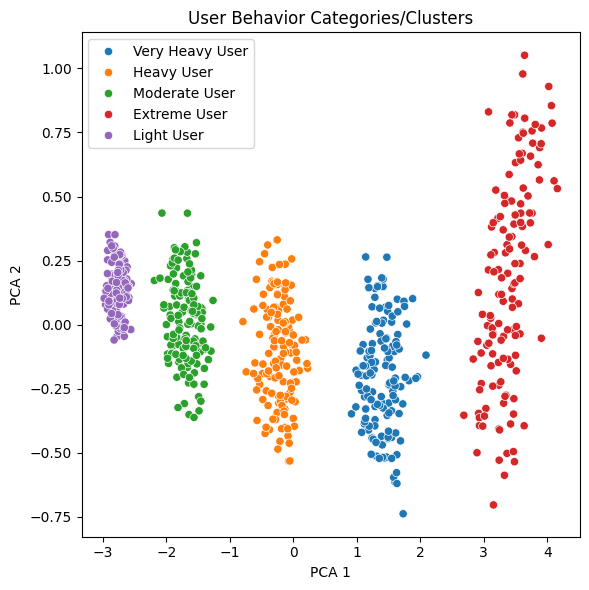

In [40]:
from sklearn.decomposition import PCA
'''
Now trying to plot this on a 2d plot so hence we need to extract features. For this, Principal Component Analysis is a great way
original data -> 5 features ("App Usage Time (min/day)", "Screen On Time (hours/day)", "Battery Drain (mAh/day)",
"Number of Apps Installed", "Data Usage (MB/day)") becomes 2D (PCA1 and PCA2 which captures maximum variance)
'''

pca = PCA(n_components=2, random_state=random_state)
X_pca = pca.fit_transform(X_scaled)

df_clust["pca1"] = X_pca[:, 0]
df_clust["pca2"] = X_pca[:, 1]

plt.figure(figsize=(6,6))
sns.scatterplot(data=df_clust, x="pca1", y="pca2", hue="Type of User")

plt.title("User Behavior Categories/Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()


'''
Regression Random Forests
'''

Device health/battery impact patterns

In [41]:
#Taking battery drain as a target to understand how battery drains based on numeric and categorical features (one hot encoded)
target_col = "Battery Drain (mAh/day)"

numeric_features = ["App Usage Time (min/day)", "Screen On Time (hours/day)", "Data Usage (MB/day)", "Number of Apps Installed", "Age"]

categorical_features = ["Device Model", "Operating System", "Gender"]

#Creating input and output (battery drain is what we need to predict, hence it is output)
X = df[numeric_features + categorical_features].copy()
y = df[target_col].copy()


In [42]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

rf = RandomForestRegressor(n_estimators=300, random_state=random_state)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", rf)
])


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['App Usage Time (min/day)',
                                                   'Screen On Time (hours/day)',
                                                   'Data Usage (MB/day)',
                                                   'Number of Apps Installed',
                                                   'Age']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Device Model',
                                                   'Operating System',
                                                   'Gender'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=300, random_state=42))])

In [44]:
y_pred = model.predict(X_test)

#Calculating metrics for regression (MAE and MSE are common metrics used) to see how the random forest has worked.
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(f"MAE : {mae:.2f} mAh/day")
print(f"RMSE: {rmse:.2f} mAh/day")


MAE : 147.84 mAh/day
RMSE: 30404.59 mAh/day


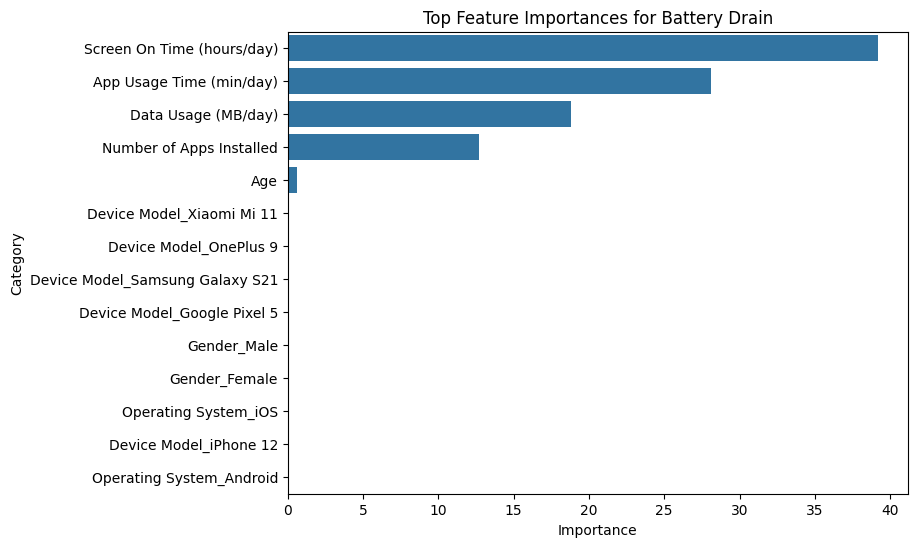

,0
Screen On Time (hours/day),39.214982
App Usage Time (min/day),28.136952
Data Usage (MB/day),18.829064
Number of Apps Installed,12.726133
Age,0.615701
Device Model_Xiaomi Mi 11,0.072423
Device Model_OnePlus 9,0.069966
Device Model_Samsung Galaxy S21,0.069887
Device Model_Google Pixel 5,0.069214
Gender_Male,0.055215


In [45]:
#I defined the model as a pipeline hence taking the random forest stage and the preprocess phase from the pipeline
rf_model = model.named_steps["rf"]
pre = model.named_steps["preprocess"]

# Categorical feature names (after one-hot). Gives all the unique categories.
one_hot_encoder = pre.named_transformers_["cat"]
one_hot_encoder = one_hot_encoder.get_feature_names_out(categorical_features)

feature_names = np.concatenate([numeric_features, one_hot_encoder])

#Getting the importance of each feature as compared to original output column (battery drain)
importance_of_each_feature = rf_model.feature_importances_

#Converting the features to series so that we can plot it easily.
feat_imp = pd.Series(importance_of_each_feature * 100, index=feature_names).sort_values(ascending=False)

#Creating a figure to plot the values
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top Feature Importances for Battery Drain")
plt.xlabel("Importance")
plt.ylabel("Category")
plt.show()

#Showing the same without a plot and as a table
feat_imp.head(15)


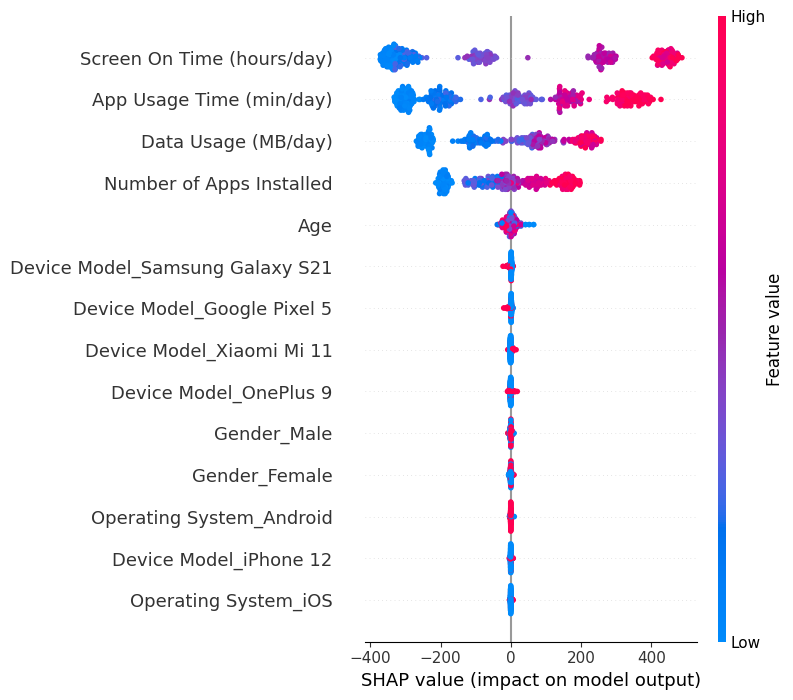

In [46]:
# Taking a small sample of data (350 features) randomly to get the global importance summary (Shap is slow and few samples should be enough. Took almost 50 percent)
X_sample = X_train.sample(350, random_state=random_state)

# Preprocessing is happening same as data training using pipeline
X_sample_transformed = preprocessor.transform(X_sample)

#Instantiating SHAP explainer class and getting values from it
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_sample_transformed)

# Plotting SHAP values
shap.summary_plot(shap_values, X_sample_transformed, feature_names=feature_names)


'''
Regression using XGBoost
'''

In [47]:
target_col = "Data Usage (MB/day)"

# One-hot encode any categorical columns
df = pd.get_dummies(df, drop_first=True)

X = df.drop(columns=[target_col, 'User Behavior Class', "User ID"])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n=== XGBoost Results ===")
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("RMSE:", rmse_xgb)
print("MAE:", mae_xgb)


=== XGBoost Results ===
RMSE: 158.04635519563556
MAE: 119.65047454833984


In [48]:
# 1. Access feature importances from the retrained XGBoost model
feature_importances_updated = xgb_model.feature_importances_

# 2. Create a Pandas DataFrame
feature_names_updated = X_train.columns
df_feature_importances_updated = pd.DataFrame({
    'Feature': feature_names_updated,
    'Importance': feature_importances_updated
})

# 3. Sort the DataFrame by importance scores in descending order
df_feature_importances_updated = df_feature_importances_updated.sort_values(by='Importance', ascending=False)

print("Feature Importances from Updated XGBoost Model (Sorted):")
print(df_feature_importances_updated.head(10))

Feature Importances from Updated XGBoost Model (Sorted):
                            Feature  Importance
2           Battery Drain (mAh/day)    0.487248
3          Number of Apps Installed    0.219907
0          App Usage Time (min/day)    0.118666
1        Screen On Time (hours/day)    0.082856
5            Device Model_OnePlus 9    0.022458
4                               Age    0.013348
9              Operating System_iOS    0.013066
8            Device Model_iPhone 12    0.012637
6   Device Model_Samsung Galaxy S21    0.011850
10                      Gender_Male    0.010454


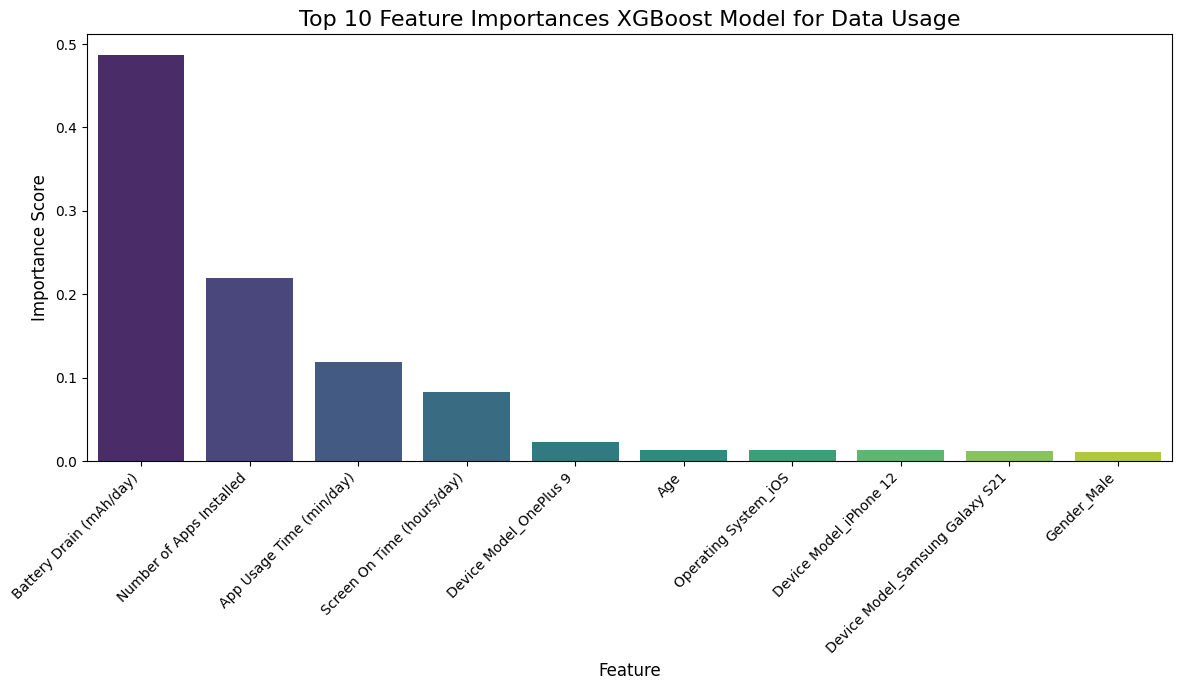

In [49]:
# Select the top 10 most important features from the updated DataFrame
top_10_features_updated = df_feature_importances_updated.head(10)

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Feature', y='Importance', hue='Feature', data=top_10_features_updated, palette='viridis', legend=False)

# Set title and labels
plt.title('Top 10 Feature Importances XGBoost Model for Data Usage', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Ensure tight layout and display the plot
plt.tight_layout()
plt.show()